In [ ]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

100%|██████████| 170498071/170498071 [00:04<00:00, 37127105.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


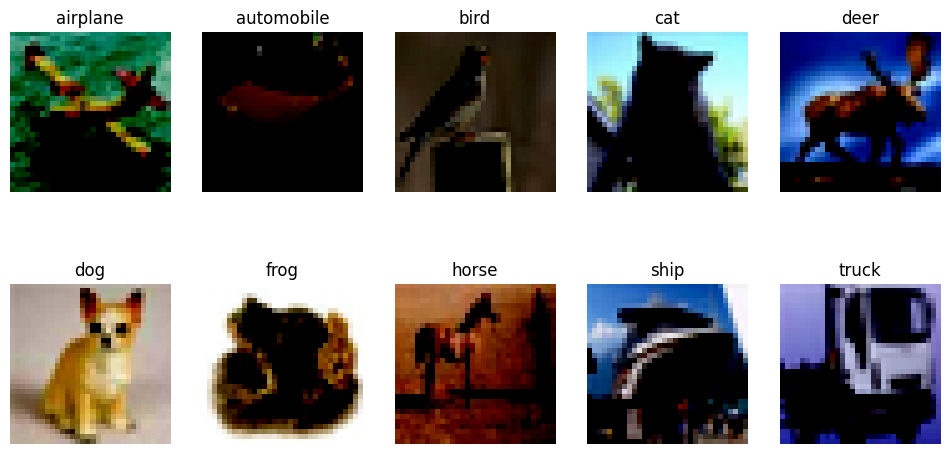

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get one image from each class
class_images = []
for i in range(len(class_names)):
    for data, target in trainloader:
        if target[0] == i:
            class_images.append(data[0])
            break

# Plot one image from each class
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(len(class_names)):
    ax = axs[i // 5, i % 5]
    ax.imshow(np.transpose(class_images[i], (1, 2, 0)))
    ax.set_title(class_names[i])
    ax.axis('off')

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 47571466.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Initialize the model and optimizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = ResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_acc = []
val_acc = []

In [ ]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)
    # Validation loop
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)

    print(f"[Epoch {epoch+1}] Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

print("Finished training")


[Epoch 1] Train Loss: 1.5051 | Train Acc: 44.71% | Val Loss: 1.1801 | Val Acc: 57.81%
[Epoch 2] Train Loss: 1.0396 | Train Acc: 62.66% | Val Loss: 0.9463 | Val Acc: 66.63%
[Epoch 3] Train Loss: 0.8453 | Train Acc: 70.08% | Val Loss: 0.8583 | Val Acc: 69.64%
[Epoch 4] Train Loss: 0.7084 | Train Acc: 75.01% | Val Loss: 0.6801 | Val Acc: 76.90%
[Epoch 5] Train Loss: 0.6172 | Train Acc: 78.40% | Val Loss: 0.6629 | Val Acc: 77.15%
[Epoch 6] Train Loss: 0.5450 | Train Acc: 81.03% | Val Loss: 0.6130 | Val Acc: 78.93%
[Epoch 7] Train Loss: 0.4883 | Train Acc: 83.05% | Val Loss: 0.5778 | Val Acc: 79.90%
[Epoch 8] Train Loss: 0.4442 | Train Acc: 84.78% | Val Loss: 0.4983 | Val Acc: 83.11%
[Epoch 9] Train Loss: 0.4080 | Train Acc: 85.87% | Val Loss: 0.4711 | Val Acc: 83.75%
[Epoch 10] Train Loss: 0.3742 | Train Acc: 87.12% | Val Loss: 0.5255 | Val Acc: 82.18%
Finished training


In [ ]:
# Test loop
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f} | Test Acc: {100 * correct_test / total_test:.2f}%")


Test Loss: 0.5082 | Test Acc: 82.77%


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

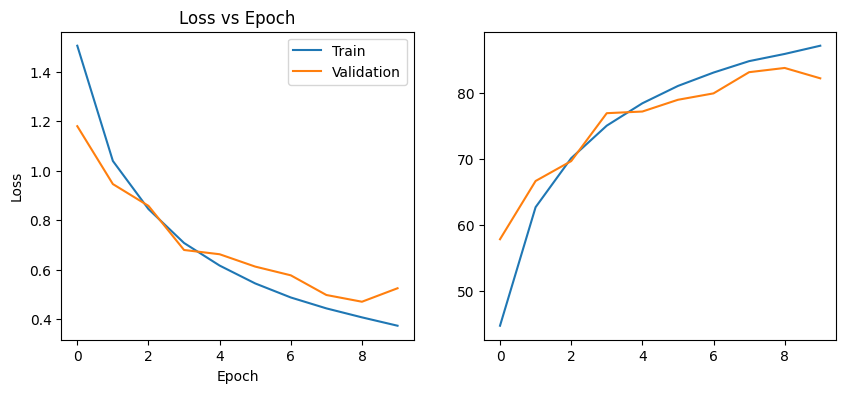

In [ ]:

# Plot loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel


In [ ]:
# Save the trained model
torch.save(model.state_dict(), "resnet_cifar10.pth")
print("Model saved as resnet_cifar10.pth")

Model saved as resnet_cifar10.pth


In [ ]:
# Changing the number of layers to 5

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet2(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet2, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.layer5 = self._make_layer(1024, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
model = ResNet2().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_acc = []
val_acc = []

In [ ]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)
    # Validation loop
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)

    print(f"[Epoch {epoch+1}] Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

print("Finished training")


[Epoch 1] Train Loss: 1.5996 | Train Acc: 41.12% | Val Loss: 1.2674 | Val Acc: 54.48%
[Epoch 2] Train Loss: 1.1166 | Train Acc: 60.12% | Val Loss: 1.0767 | Val Acc: 62.10%
[Epoch 3] Train Loss: 0.8901 | Train Acc: 68.60% | Val Loss: 0.8801 | Val Acc: 69.85%
[Epoch 4] Train Loss: 0.7412 | Train Acc: 74.01% | Val Loss: 0.7456 | Val Acc: 74.47%
[Epoch 5] Train Loss: 0.6463 | Train Acc: 77.43% | Val Loss: 0.6965 | Val Acc: 75.92%
[Epoch 6] Train Loss: 0.5689 | Train Acc: 80.41% | Val Loss: 0.6533 | Val Acc: 77.68%
[Epoch 7] Train Loss: 0.5199 | Train Acc: 82.08% | Val Loss: 0.5545 | Val Acc: 81.54%
[Epoch 8] Train Loss: 0.4739 | Train Acc: 83.58% | Val Loss: 0.5063 | Val Acc: 82.36%
[Epoch 9] Train Loss: 0.4311 | Train Acc: 85.22% | Val Loss: 0.4886 | Val Acc: 83.07%
[Epoch 10] Train Loss: 0.3947 | Train Acc: 86.43% | Val Loss: 0.4842 | Val Acc: 83.83%
Finished training


In [ ]:
# Test loop
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f} | Test Acc: {100 * correct_test / total_test:.2f}%")


Test Loss: 0.4981 | Test Acc: 83.70%


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

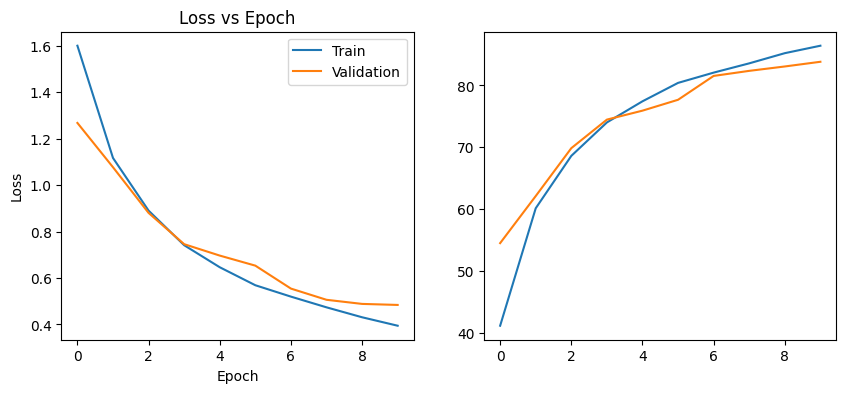

In [ ]:
# Plot loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "resnet2_cifar10.pth")
print("Model saved as resnet2_cifar10.pth")

Model saved as resnet2_cifar10.pth


In [ ]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 4)
        self.conv2 = nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels // 4)
        self.conv3 = nn.Conv2d(out_channels // 4, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(BottleneckBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BottleneckBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
model3 = ResNet(num_classes=10).to(device)

In [ ]:
optimizer = optim.Adam(model3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_acc = []
val_acc = []

In [ ]:
for epoch in range(10):
    model3.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)
    # Validation loop
    model3.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model3(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)

    print(f"[Epoch {epoch+1}] Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

print("Finished training")


[Epoch 1] Train Loss: 1.6245 | Train Acc: 40.17% | Val Loss: 1.3027 | Val Acc: 52.73%
[Epoch 2] Train Loss: 1.1861 | Train Acc: 57.18% | Val Loss: 1.0969 | Val Acc: 60.98%
[Epoch 3] Train Loss: 0.9784 | Train Acc: 65.20% | Val Loss: 0.9710 | Val Acc: 65.56%
[Epoch 4] Train Loss: 0.8415 | Train Acc: 70.39% | Val Loss: 0.9039 | Val Acc: 69.05%
[Epoch 5] Train Loss: 0.7330 | Train Acc: 74.39% | Val Loss: 0.7553 | Val Acc: 73.95%
[Epoch 6] Train Loss: 0.6544 | Train Acc: 77.17% | Val Loss: 0.6489 | Val Acc: 77.62%
[Epoch 7] Train Loss: 0.6019 | Train Acc: 78.97% | Val Loss: 0.7764 | Val Acc: 73.52%
[Epoch 8] Train Loss: 0.5573 | Train Acc: 80.68% | Val Loss: 0.5363 | Val Acc: 81.35%
[Epoch 9] Train Loss: 0.5257 | Train Acc: 81.67% | Val Loss: 0.5916 | Val Acc: 80.17%
[Epoch 10] Train Loss: 0.4878 | Train Acc: 83.06% | Val Loss: 0.5397 | Val Acc: 81.29%
Finished training


In [ ]:
# Test loop
model3.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model3(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f} | Test Acc: {100 * correct_test / total_test:.2f}%")

Test Loss: 0.5543 | Test Acc: 81.55%


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

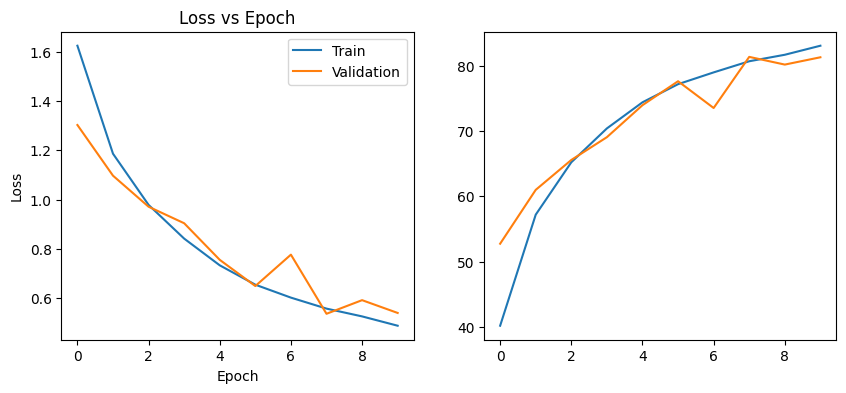

In [ ]:
# Plot loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel

In [ ]:
# Save the trained model
torch.save(model3.state_dict(), "resnet3_cifar10.pth")
print("Model saved as resnet3_cifar10.pth")

Model saved as resnet3_cifar10.pth


In [ ]:
import torch.nn.functional as F

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)  # Added dropout for regularization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout after ReLU
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
num_blocks = [2, 2, 2, 2]  # This is for ResNet18

# Create an instance of the ResNet
model4 = ResNet(ResidualBlock, num_blocks, num_classes=10).to(device)

In [ ]:
optimizer = optim.Adam(model4.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_acc = []
val_acc = []

In [ ]:
for epoch in range(10):
    model4.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)
    # Validation loop
    model4.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model4(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_losses.append(running_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)

    print(f"[Epoch {epoch+1}] Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.2f}%")

print("Finished training")

[Epoch 1] Train Loss: 1.5586 | Train Acc: 42.47% | Val Loss: 1.2671 | Val Acc: 54.31%
[Epoch 2] Train Loss: 1.1374 | Train Acc: 59.26% | Val Loss: 1.0955 | Val Acc: 61.45%
[Epoch 3] Train Loss: 0.9611 | Train Acc: 65.97% | Val Loss: 0.8544 | Val Acc: 69.91%
[Epoch 4] Train Loss: 0.8392 | Train Acc: 70.38% | Val Loss: 0.8007 | Val Acc: 72.23%
[Epoch 5] Train Loss: 0.7438 | Train Acc: 73.86% | Val Loss: 0.6602 | Val Acc: 77.22%
[Epoch 6] Train Loss: 0.6753 | Train Acc: 76.36% | Val Loss: 0.5845 | Val Acc: 79.87%
[Epoch 7] Train Loss: 0.6173 | Train Acc: 78.51% | Val Loss: 0.5911 | Val Acc: 79.96%
[Epoch 8] Train Loss: 0.5698 | Train Acc: 80.03% | Val Loss: 0.5212 | Val Acc: 82.09%
[Epoch 9] Train Loss: 0.5329 | Train Acc: 81.61% | Val Loss: 0.5054 | Val Acc: 82.16%
[Epoch 10] Train Loss: 0.5035 | Train Acc: 82.42% | Val Loss: 0.4595 | Val Acc: 83.89%
Finished training


In [ ]:
# Test loop
model4.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model4(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f} | Test Acc: {100 * correct_test / total_test:.2f}%")

Test Loss: 0.4932 | Test Acc: 83.45%


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

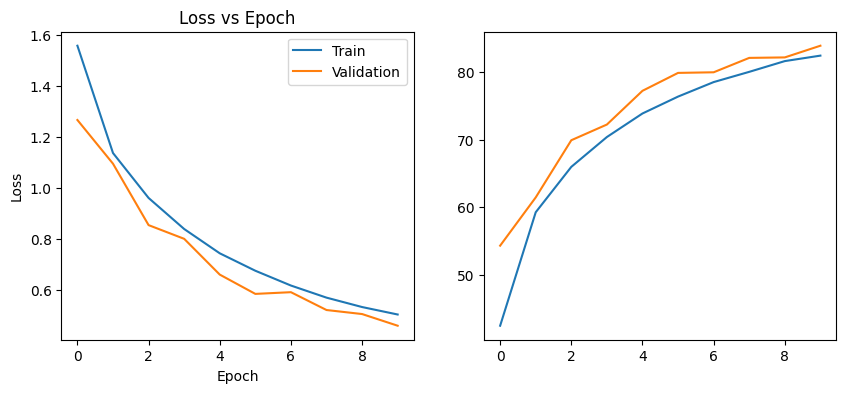

In [ ]:
# Plot loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel

In [ ]:
# Save the trained model
torch.save(model4.state_dict(), "resnet4_cifar10.pth")
print("Model saved as resnet3_cifar10.pth")

Model saved as resnet3_cifar10.pth
